## Convolutional Networks

We'll check out how to build a **convolutional network** to classify CIFAR10 images. By using weight sharing - multiple units with the same weights - convolutional layers are able to learn repeated patterns in your data. For example, a unit could learn the pattern for an eye, or a face, or lower level features like edges.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
from torch import optim, nn
import torch.nn.functional as F

%matplotlib inline 
import matplotlib.pyplot as plt

from torchsummary import summary  # install with 'pip install torchsummary'
from tensorboardX import SummaryWriter

from models import ConvNet, ConvNet_Type2
from utils import plot_images, get_train_valid_loader, plot_weights, plot_gradient_flow

Files already downloaded and verified
Files already downloaded and verified


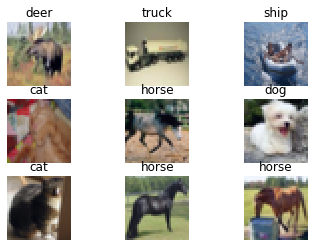

In [9]:
# get data loaders
trainloader, valloader = get_train_valid_loader()

In [10]:
# init net
net = ConvNet_Type2()

# plot net parameters
summary(net, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 32, 32]           1,824
         MaxPool2d-2           [-1, 24, 16, 16]               0
            Conv2d-3           [-1, 12, 16, 16]           2,604
         MaxPool2d-4             [-1, 12, 8, 8]               0
            Linear-5                   [-1, 96]          73,824
            Linear-6                   [-1, 10]             970
Total params: 79,222
Trainable params: 79,222
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.26
Params size (MB): 0.30
Estimated Total Size (MB): 0.58
----------------------------------------------------------------


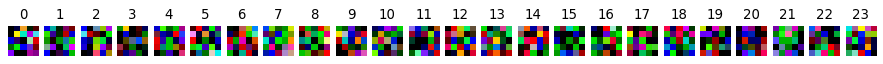

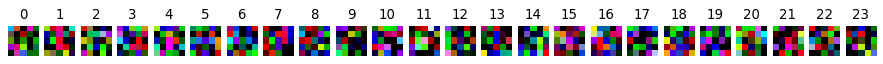

In [11]:
# visualize init weights
w = net.conv1.weight.data.numpy()
plot_weights(w,scaling=True)

In [12]:
################################################################################
# TODO:                                                                        #
# Choose an Optimizer that will be used to minimize the loss function.         #
# Choose a critera that measures the loss                                      #
################################################################################
learning_rate = 1e-3
decayRate = 0.2
l2_reg = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=l2_reg)

# https://discuss.pytorch.org/t/how-to-do-exponential-learning-rate-decay-in-pytorch/63146/3
# https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=decayRate, patience=3, threshold=1e-2, verbose = True)


epochs = 30
running_loss = 0
print_every = 200
training_steps = 0

# init tensorboard writer
writer = SummaryWriter()

val_acc_best = 0

for e in range(epochs):
    
    print('\n--- EPOCH %03d / %03d STARTED ---' % (e+1, epochs))
 
    # set net to train mode
    net.train()
    
    # log current learning rate
    writer.add_scalar('optimizer/learning_rate', optimizer.param_groups[0]['lr'], e+1)
    
    # train over all batches
    start = time.time()
    for idx_batch, (images, labels) in enumerate(trainloader):
        
        training_steps += 1
        
        if idx_batch % print_every == 0:
            print('---> train on batch %03d' % idx_batch)
        
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        plot_gradient_flow(net.named_parameters())
        
        optimizer.step()
        
        writer.add_scalar('train/loss_training_step', loss.item(), training_steps)
        
    # set net to evaluation mode
    net.eval()
    
    # evaluate on training data 
    train_loss_accum = 0.
    count_total = 0
    count_correct = 0
    for idx_batch, (images, labels) in enumerate(trainloader):
        output = net(images)
        loss = criterion(output, labels)
        train_loss_accum += loss.item()
        
        prediction = torch.argmax(F.softmax(output), axis=1)
        count_total += prediction.size(0)
        count_correct += (prediction == labels).sum().item()
        
    train_loss_avg = train_loss_accum / (idx_batch+1)
    train_acc = count_correct / count_total
    writer.add_scalar('train/loss_epoch', train_loss_avg, e+1)
    writer.add_scalar('train/accuracy', train_acc, e+1)
    
    # evaluate on validation data 
    val_loss_accum = 0.
    count_total = 0
    count_correct = 0
    for idx_batch, (images, labels) in enumerate(valloader):
        output = net(images)
        loss = criterion(output, labels)
        val_loss_accum += loss.item()
        
        prediction = torch.argmax(F.softmax(output), axis=1)
        count_total += prediction.size(0)
        count_correct += (prediction == labels).sum().item()

    val_loss_avg = val_loss_accum / (idx_batch+1)
    val_acc = count_correct / count_total
    writer.add_scalar('val/loss_epoch', val_loss_avg, e+1)
    writer.add_scalar('val/accuracy', val_acc, e+1)
    
    print('\nMetrics: ')
    print('---> train loss / accuracy: %.03f / %.03f' % (train_loss_avg, train_acc))
    print('---> val loss / accuracy:   %.03f / %.03f' % (val_loss_avg, val_acc))
    
    scheduler.step(val_loss_avg)
    
    # print('filters conv1')
    # w1 = net.conv1.weight.data.numpy()
    # plot_weights(w1, scaling=True)
    # plt.show()
    
    if val_acc > val_acc_best:
        val_acc_best = val_acc
        print('---> save new best checkpoint')
        torch.save(net.state_dict(), 'model_%.03f.ckpt' % val_acc)

# close tensorboard logging
writer.close()


--- EPOCH 001 / 030 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> train on batch 600


/Users/theo/anaconda3/envs/deep/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/theo/anaconda3/envs/deep/lib/python3.7/site-packages/ipykernel_launcher.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Metrics: 
---> train loss / accuracy: 1.306 / 0.535
---> val loss / accuracy:   1.351 / 0.515
---> save new best checkpoint

--- EPOCH 002 / 030 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> train on batch 600

Metrics: 
---> train loss / accuracy: 1.114 / 0.605
---> val loss / accuracy:   1.173 / 0.587
---> save new best checkpoint

--- EPOCH 003 / 030 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> train on batch 600

Metrics: 
---> train loss / accuracy: 1.061 / 0.633
---> val loss / accuracy:   1.114 / 0.621
---> save new best checkpoint

--- EPOCH 004 / 030 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> train on batch 600

Metrics: 
---> train loss / accuracy: 0.975 / 0.664
---> val loss / accuracy:   1.005 / 0.634
---> save new best checkpoint

--- EPOCH 005 / 030 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> tra

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x11b4e3680> (for post_execute):


KeyboardInterrupt: 

Save best trained model.